# NYC Apartment Search

## Final Project - Group 1: Hanlong Cheng & Princeton Huang

## Setup

Below are the all of the import statements needed for the project.

In [2]:
import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import requests
import shapely
import sqlalchemy as db
import psycopg2

from sqlalchemy.orm import declarative_base

import numpy as np
from sqlalchemy import create_engine, text

from geoalchemy2 import WKTElement, Geometry

Below are the various constants needed for the project, as well as the relevant file storage directories.

In [3]:
# Where data files will be read from/written to.
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "tduReHVOIB700AKqHU1FC5Za7"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "Final_Project"
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# Directory for database queries from part 3.
QUERY_DIR = pathlib.Path("queries")

endpoint_311_1 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2022-10-01' and'2023-10-01'&$limit=3500000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"
endpoint_311_2 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2015-01-01' and'2017-01-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"
endpoint_311_3 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2017-01-01' and'2019-01-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"                                                 
endpoint_311_4 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2019-01-01' and'2021-01-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"                                                 
                                                 
endpoint_311_5 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                "$select= created_date, incident_zip, complaint_type, latitude, longitude&"\
                "$where= created_date between '2021-01-01' and'2022-10-01'&$limit=5000000&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}"                                                 
                                                 
endpoint_trees = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                "$select=tree_id, the_geom, zipcode, zip_city, health, spc_common, status&"\
                f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=65000 &$where= zip_city='New York'"                                                                  

## Part 1: Data Preprocessing

### Loading and Cleaning

Initiate the process of downloading data from the NYC database.

In [21]:
def download_nyc_geojson_data(url, app_token, force=False):
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = DATA_DIR / url_path
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        headers = {'X-App-Token': app_token}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            filename.parent.mkdir(parents=True, exist_ok=True)
            with open(filename, "w") as f:
                json.dump(response.json(), f)
            print(f"Done downloading {url}.")
        else:
            print(f"Failed to download dataset. Status code: {response.status_code}")
    else:
        print(f"Reading from {filename}...")
    
    return filename

Load and clean shapefiles data from NYC’s zip codes with geometric boundary data, then return a geopandas dataframe.

In [22]:
def load_and_clean_zipcodes():
    zipcodes_df = gpd.read_file (ZIPCODE_DATA_FILE)
    zipcodes_df = zipcodes_df [zipcodes_df['PO_NAME'] == 'New York']
    zipcodes_df. rename(columns={'ZIPCODE':'zipcode'},inplace=True)
    zipcodes_df = zipcodes_df. drop_duplicates ()
    zipcodes_df = zipcodes_df.to_crs(epsg=4326)
    return zipcodes_df[["zipcode", "geometry"]]

Programatically download and clean historical data from NYC Open Data on 311 complaints, as well as the 2015 tree census, then return a geopandas dataframe.

In [23]:
def download_and_clean_311_data():
    content = requests.get(endpoint_311_1)
    print(content)
    data_311_1 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_2)
    data_311_2 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_3)
    data_311_3 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_4)
    data_311_4 = gpd.read_file(content.text)
    print(content)
    content = requests.get (endpoint_311_5)
    data_311_5 = gpd.read_file(content.text)
    print(content)
    data_311 = pd.concat ([data_311_1, data_311_2, data_311_3, data_311_4, data_311_5], axis=0, ignore_index=True)
    data_311. rename(columns={"incident_zip":
    'zipcode'}, inplace=True)
    if "geometry" in data_311.columns:
        data_311. drop ('geometry' ,axis=1, inplace=True)
    return data_311

In [24]:
def download_and_clean_tree_data():
    content = requests. get (endpoint_trees)
    data_tree = gpd. read_file(content.text). reset_index()
    data_tree. rename(columns={' spc_common': 'species'}, inplace=True)
    data_tree. rename(columns={'the_geom': 'geometry'}, inplace=True)
    data_tree.drop('index',axis=1, inplace=True)
    return data_tree

Load and clean historical monthly average rent data by zip code from Zillow, then return a pandas dataframe.

In [25]:
def load_and_clean_zillow_data():
    zillow_df = gpd. read_file (ZILLOW_DATA_FILE)
    zillow_df = zillow_df[zillow_df['City'] =='New York']
    date_columns = [col for col in zillow_df if col >= '2015-01-31' and col <= '2023-09-30']
    for col in date_columns:
        zillow_df [col] = pd. to_numeric(zillow_df [col], errors='coerce')
    zillow_df. rename(columns={'RegionID':'regionid'}, inplace=True)
    zillow_df. rename(columns={'RegionName': 'zipcode'},inplace=True)
    zillow_df['average_rent'] = zillow_df [date_columns].mean(axis=1, skipna=True)
    return zillow_df[["regionid", 'zipcode', '2023-01-31', '2023-08-31', '2023-09-30', 'average_rent']]

Load and return all data as the tuple of all four dataframes.

In [26]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes()
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [27]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


### Referencing Data

Identify basic information about each dataframe.

In [30]:
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 109 entries, 21 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   109 non-null    object  
 1   geometry  109 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.6+ KB


Display the first five entries for each dataframe.

In [31]:
geodf_zipcode_data.head()

zipcode                                           geometry
21   10034  POLYGON ((-73.92062 40.87300, -73.92058 40.873...
22   10033  POLYGON ((-73.93213 40.86945, -73.93186 40.869...
24   10040  POLYGON ((-73.93379 40.86307, -73.93367 40.863...
32   10032  POLYGON ((-73.94692 40.85053, -73.94688 40.850...
36   10031  POLYGON ((-73.94009 40.83035, -73.93979 40.829...

In [32]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22876175 entries, 0 to 22876174
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        object        
 1   created_date    datetime64[ns]
 2   longitude       object        
 3   zipcode         object        
 4   complaint_type  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 872.7+ MB


In [29]:
geodf_311_data.head()

latitude        created_date           longitude zipcode  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623   11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191   11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275   10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197   11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267   11226   

            complaint_type  
0  Noise - Street/Sidewalk  
1      Noise - Residential  
2       Noise - Commercial  
3      Noise - Residential  
4      Noise - Residential

In [17]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64488 entries, 0 to 64487
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   health      61495 non-null  object  
 1   zipcode     64488 non-null  object  
 2   tree_id     64488 non-null  object  
 3   spc_common  61496 non-null  object  
 4   zip_city    64488 non-null  object  
 5   status      64488 non-null  object  
 6   geometry    64488 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 3.4+ MB


In [33]:
geodf_tree_data.head()

health zipcode tree_id       spc_common  zip_city status  \
0   Good   10023  190422      honeylocust  New York  Alive   
1   Good   10023  190426      honeylocust  New York  Alive   
2   Good   10019  208649  American linden  New York  Alive   
3   Good   10021  193310      honeylocust  New York  Alive   
4   Fair   10024  199760       willow oak  New York  Alive   

                     geometry  
0  POINT (-73.98495 40.77005)  
1  POINT (-73.98534 40.77021)  
2  POINT (-73.98730 40.76272)  
3  POINT (-73.96046 40.77217)  
4  POINT (-73.98096 40.78209)

In [34]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 4 to 6721
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   regionid      145 non-null    object 
 1   zipcode       145 non-null    object 
 2   2023-01-31    121 non-null    float64
 3   2023-08-31    138 non-null    float64
 4   2023-09-30    145 non-null    float64
 5   average_rent  145 non-null    float64
dtypes: float64(4), object(2)
memory usage: 7.9+ KB


In [35]:
df_zillow_data.head()

regionid zipcode   2023-01-31   2023-08-31   2023-09-30  average_rent
4     62093   11385  2895.699421  3064.476503  3079.585783   2476.923402
6     62019   11208  2588.030194  2737.547470  2728.733333   2560.469803
12    62046   11236          NaN  2285.460026  2362.500000   2323.980013
13    61807   10467  2155.617718  2353.686402  2423.888889   1861.072982
14    62085   11373  2255.604528  2302.557354  2292.994444   2084.549636

## Part 2: Storing Data

### Building Tables

Create four database tables to store the previously-loaded data.

In [6]:
engine = db.create_engine(DB_URL)

Define SQL statements to generate each table.

In [47]:
ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
        id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geom GEOMETRY
    )
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS nyc_311 (
        id INTEGER PRIMARY KEY,
        created_date DATE,
        zipcode VARCHAR,
        complaint_type VARCHAR,
        longitude REAL,
        latitude REAL
    )
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS trees (
        tree_id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geo GEOMETRY,
        health VARCHAR,
        species VARCHAR,
        status VARCHAR

    )
    """

ZILLOW_SCHEMA = """
    CREATE TABLE IF NOT EXISTS rent (
        regionid INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        "2023-01-31" REAL,
        "2023-08-31" REAL,
        "2023-09-30" REAL,
        average_rent REAL

    )
    """

Create and write into the required "schema.sql" files.

In [74]:
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

Execute the schema files to build the necessary tables.

In [75]:
conn = psycopg2.connect (f"dbname={DB_NAME} user={DB_USER} password={DB_PASSWORD} host={DB_HOST}")
cur = conn.cursor()

with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Data Entry

Write data into the corresponding tables using SQL.

**"tablename_to_dataframe" represents a "dict", where "tablename": "dataframe"**

In [69]:
def write_dataframes_to_table(tablename_to_dataframe):
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            # Create a copy of the dataframe, in order to avoid modifying the original.
            temp_df = dataframe.copy()
            
            # Convert the "geometry" column to WKTElement.
            temp_df['the_geom'] = temp_df['geometry'].apply(
                lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None
            )
            
            # Drop the original "geometry" column.
            temp_df.drop('geometry', axis=1, inplace=True)
            
            # Write the dataframe to the SQL table.
            temp_df.to_sql(
                tablename, 
                engine, 
                if_exists='replace', 
                index=False, 
                dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}
            )
        else:
            # Write the dataframe to the SQL table, excluding "geometry".
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [73]:
tablename_to_dataframe = {"zipcodes": geodf_zipcode_data,
                          "rents": df_zillow_data,
                         "trees": geodf_tree_data}

# "complaints": geodf_311_data,
# "trees": geodf_tree_data,
# "rents": df_zillow_data,

Execute the previously-defined function to achieved the desired objective.

In [72]:
write_dataframes_to_table(tablename_to_dataframe)

## Part 3: Understanding the Data

In [80]:
def write_query_to_file(query, filename):
    with open(filename, 'w') as file:
        file.write(query)

### Query 1

Between October 1st, 2022 and September 30th, 2023 (inclusive), find the number of 311 complaints per zip code. 

The query result should have two columns, one row per zip code, with the number of complaints in descending order.


In [99]:
QUERY_1_FILENAME = QUERY_DIR/"Q1_calm"
QUERY_1 = """
SELECT zipcode, COUNT(*) as Total_Complaints
FROM complaints
WHERE created_date BETWEEN '2022-10-1'AND '2023-09-30'
AND zipcode IS NOT NULL
GROUP BY zipcode
ORDER BY Total_Complaints DESC;
"""

In [100]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        
        print (row)

('11226', 49347)
('10467', 47358)
('10468', 44081)
('11385', 43943)
('10452', 43880)
('10457', 41537)
('10458', 41186)
('11207', 40173)
('10456', 39772)
('11201', 39344)
('10453', 38107)
('11208', 36763)
('10031', 33863)
('11221', 33114)
('10466', 32584)
('10032', 32047)
('10025', 31106)
('10462', 30760)
('11238', 30181)
('11230', 29683)
('11368', 29225)
('11220', 29064)
('10019', 28322)
('11216', 28159)
('11225', 28076)
('11235', 27838)
('11212', 27355)
('10463', 27053)
('10460', 27011)
('11203', 27000)
('10023', 26961)
('11214', 26776)
('11377', 26385)
('11101', 25995)
('10027', 25899)
('11213', 25894)
('11211', 25571)
('11234', 25567)
('10002', 25564)
('11206', 25410)
('11209', 25381)
('11215', 25334)
('11222', 25330)
('10472', 25313)
('11218', 25079)
('11233', 24973)
('11223', 24336)
('11373', 24099)
('10033', 23676)
('11237', 23391)
('11229', 22860)
('11236', 22719)
('10461', 22367)
('10034', 22334)
('10011', 22196)
('11204', 21787)
('10003', 21772)
('11210', 21423)
('10469', 2137

In [92]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [93]:
QUERY_2_FILENAME = QUERY_DIR / "Q2_most trees"
QUERY_2 = """
SELECT zipcode, COUNT(tree_id) AS Total_Trees
FROM trees
GROUP BY zipcode
ORDER BY Total_Trees DESC
LIMIT 10;
"""

In [94]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        
        print (row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [95]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3: Can I afford a place in the areas with the most trees?


In [96]:
QUERY_3_FILENAME = QUERY_DIR / "Q3_most trees zipcodes rent"
QUERY_3 = """
SELECT t.zipcode, ROUND(CAST(r."2023-08-31" AS NUMERIC),2)AS August2023
FROM trees t
JOIN rents r on t.zipcode = r.zipcode
GROUP by t.zipcode, r."2023-08-31"
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;

"""

In [97]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        
        print (row)

('10025', Decimal('4037.77'))
('10024', Decimal('3797.94'))
('10027', Decimal('3235.99'))
('10014', Decimal('4899.07'))
('10031', Decimal('2967.04'))
('10029', Decimal('2915.94'))
('10002', Decimal('4078.87'))
('10023', Decimal('4370.07'))
('10032', Decimal('2657.76'))
('10128', Decimal('3565.40'))


In [98]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 5: Where has the most greenery (take 2)?

Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table.

The query should have a JOIN statement. The query results should match exactly the results of Query 2.


In [103]:
QUERY_5_FILENAME = QUERY_DIR / "Q5_most trees"
QUERY_5 = """
SELECT t.zipcode, COUNT(t.tree_id) AS Total_Trees
FROM trees t
LEFT JOIN zip_codes z ON ST_Contains (z.the_geom, t.the_geom)
GROUP BY t.zipcode
ORDER BY Total_Trees DESC
LIMIT 10;
"""

In [104]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        
        print (row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [105]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1:: What can I expect to put up with in NYC?

First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). 

Then, create an appropriate visualization for the number of complaints per day over $timeframe for those complaint types.  


In [106]:
QUERY_4_1= """
SELECT complaint_type, COUNT(*) AS complaint_count
FROM complaints
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY complaint_type
ORDER BY complaint_count DESC
LIMIT 3;
"""

In [108]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4_1))
    for row in result:
        
        print (row)

('Illegal Parking', 455953)
('Noise - Residential', 293036)
('HEAT/HOT WATER', 237877)


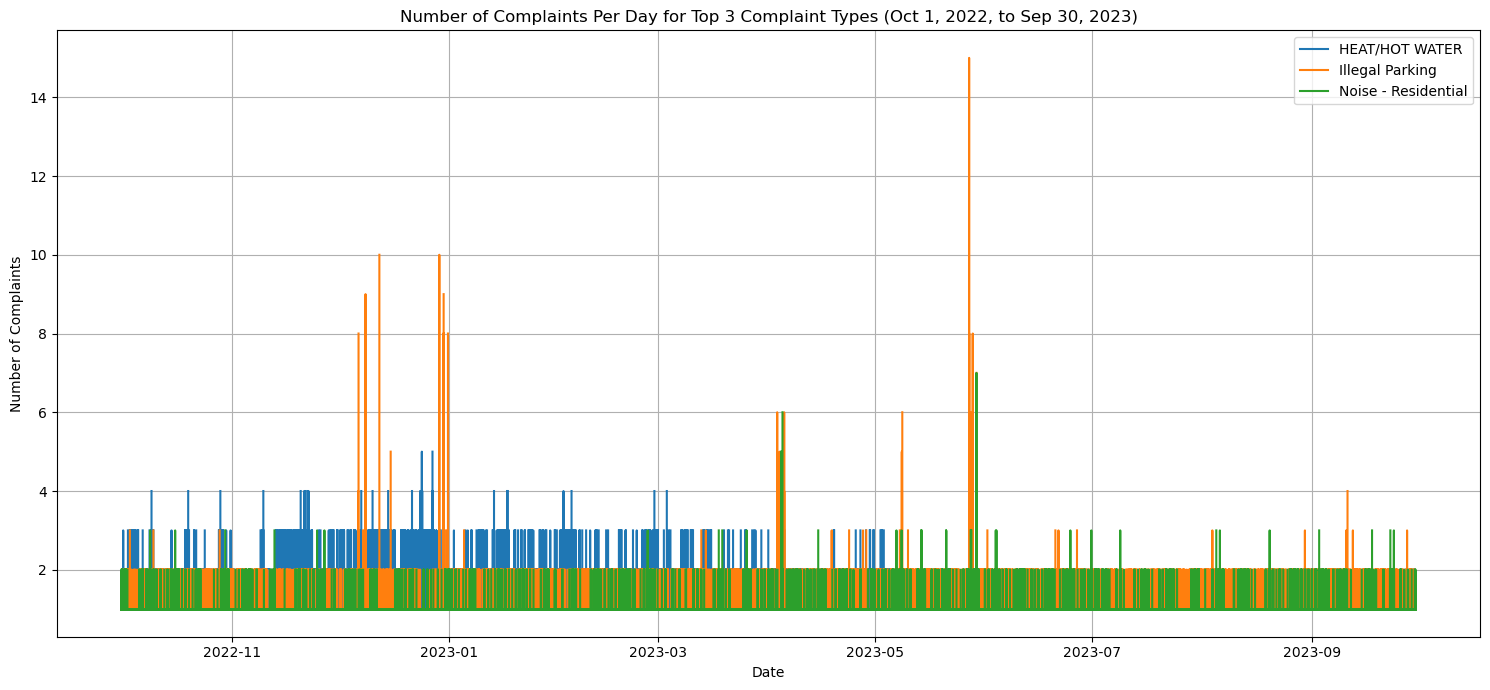

In [113]:
QUERY = """
SELECT created_date, complaint_type, COUNT(*) AS daily_complaint_count
FROM complaints
WHERE (complaint_type = 'Illegal Parking' OR 
       complaint_type = 'Noise - Residential' OR 
       complaint_type = 'HEAT/HOT WATER')
AND created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY created_date, complaint_type
ORDER BY created_date, complaint_type;
"""

# Execute the query and fetch the results into a DataFrame
with engine.connect() as conn:
    df = pd.read_sql(text(QUERY), conn)

# Pivot the DataFrame to have dates as rows and complaint types as columns
pivot_df = df.pivot(index='created_date', columns='complaint_type', values='daily_complaint_count')

# Plotting
plt.figure(figsize=(15, 7))
for complaint_type in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[complaint_type], label=complaint_type)

plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Per Day for Top 3 Complaint Types (Oct 1, 2022, to Sep 30, 2023)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

### Visualization 2: What are the most common complaints in the immediate area?

Create a visualization that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive). 

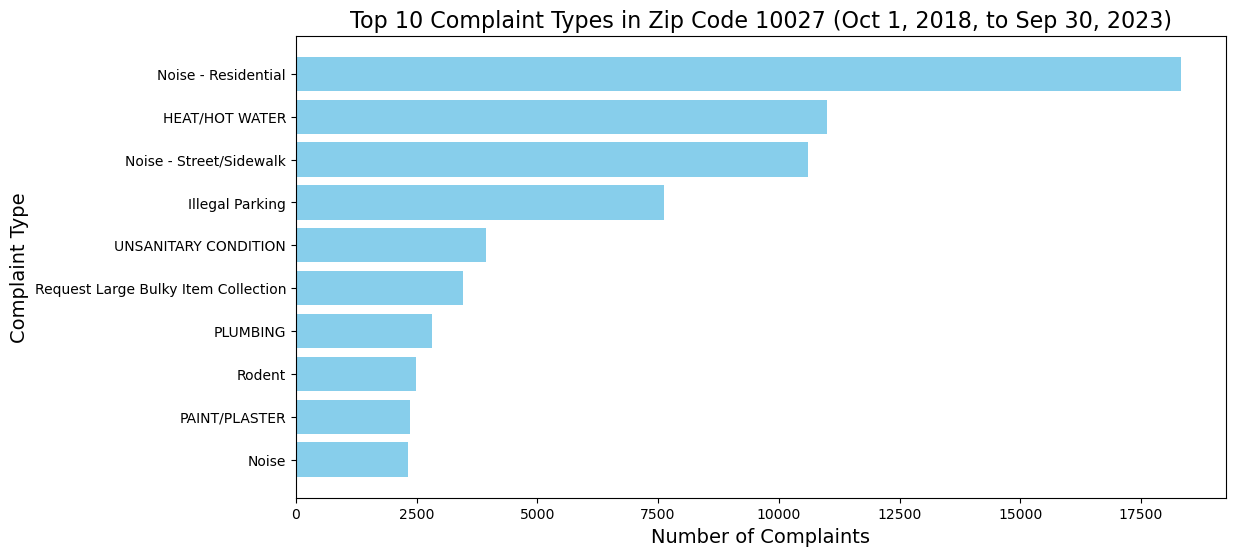

In [114]:
QUERY = """
SELECT complaint_type, COUNT(*) AS complaint_count
FROM complaints
WHERE zipcode = '10027'
AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
GROUP BY complaint_type
ORDER BY complaint_count DESC
LIMIT 10;
"""
with engine.connect() as conn:
    df = pd.read_sql(text(QUERY), conn)

# Plotting the results as a bar chart
plt.figure(figsize=(12, 6))
plt.barh(df['complaint_type'], df['complaint_count'], color='skyblue')
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Complaint Type', fontsize=14)
plt.title('Top 10 Complaint Types in Zip Code 10027 (Oct 1, 2018, to Sep 30, 2023)', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

### Visualization 3: Is there any correlation between rent, trees, and complaints at all?

Between January 1st, 2015 and September 30th, 2023 (inclusive), create a visualization using 2 subplots that share the x-axis where one subplot shows rent compared to the number of trees by zip code, and the other subplot shows rent compared to the number of complaints by zip code.

In [ ]:
# use a more descriptive name for your function
def plot_visual_1(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_1():
    # Query your database for the data needed.
    # You can put the data queried into a pandas/geopandas dataframe, if you wish
    raise NotImplementedError()

In [ ]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)